## Advanced Clustering Analysis of Mental Health Profiles<br>
<hr>

In [1]:
# Step 1: Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from kmodes.kprototypes import KPrototypes
from gap_statistic import OptimalK
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")


In [2]:
# Load the mental health dataset
data = pd.read_csv("C:\\Users\\supri\\OneDrive\\Desktop\\DAEN 3rd SEM\\AIT 736\\mhcld_puf_2021.csv")
# Step 2: Data Preprocessing
# Drop irrelevant columns
data.drop(['YEAR', 'CASEID'], axis=1, inplace=True)

# Handling missing values (assuming -9 is used for missing values)
data.replace(-9, np.nan, inplace=True)
# Drop rows with any missing values
data.dropna(inplace=True)

In [3]:
data.shape

(13151, 38)

In [4]:
data.columns.unique()

Index(['AGE', 'EDUC', 'ETHNIC', 'RACE', 'GENDER', 'SPHSERVICE', 'CMPSERVICE',
       'OPISERVICE', 'RTCSERVICE', 'IJSSERVICE', 'MH1', 'MH2', 'MH3', 'SUB',
       'MARSTAT', 'SMISED', 'SAP', 'EMPLOY', 'DETNLF', 'VETERAN', 'LIVARAG',
       'NUMMHS', 'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG',
       'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG',
       'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG', 'STATEFIP',
       'DIVISION', 'REGION'],
      dtype='object')

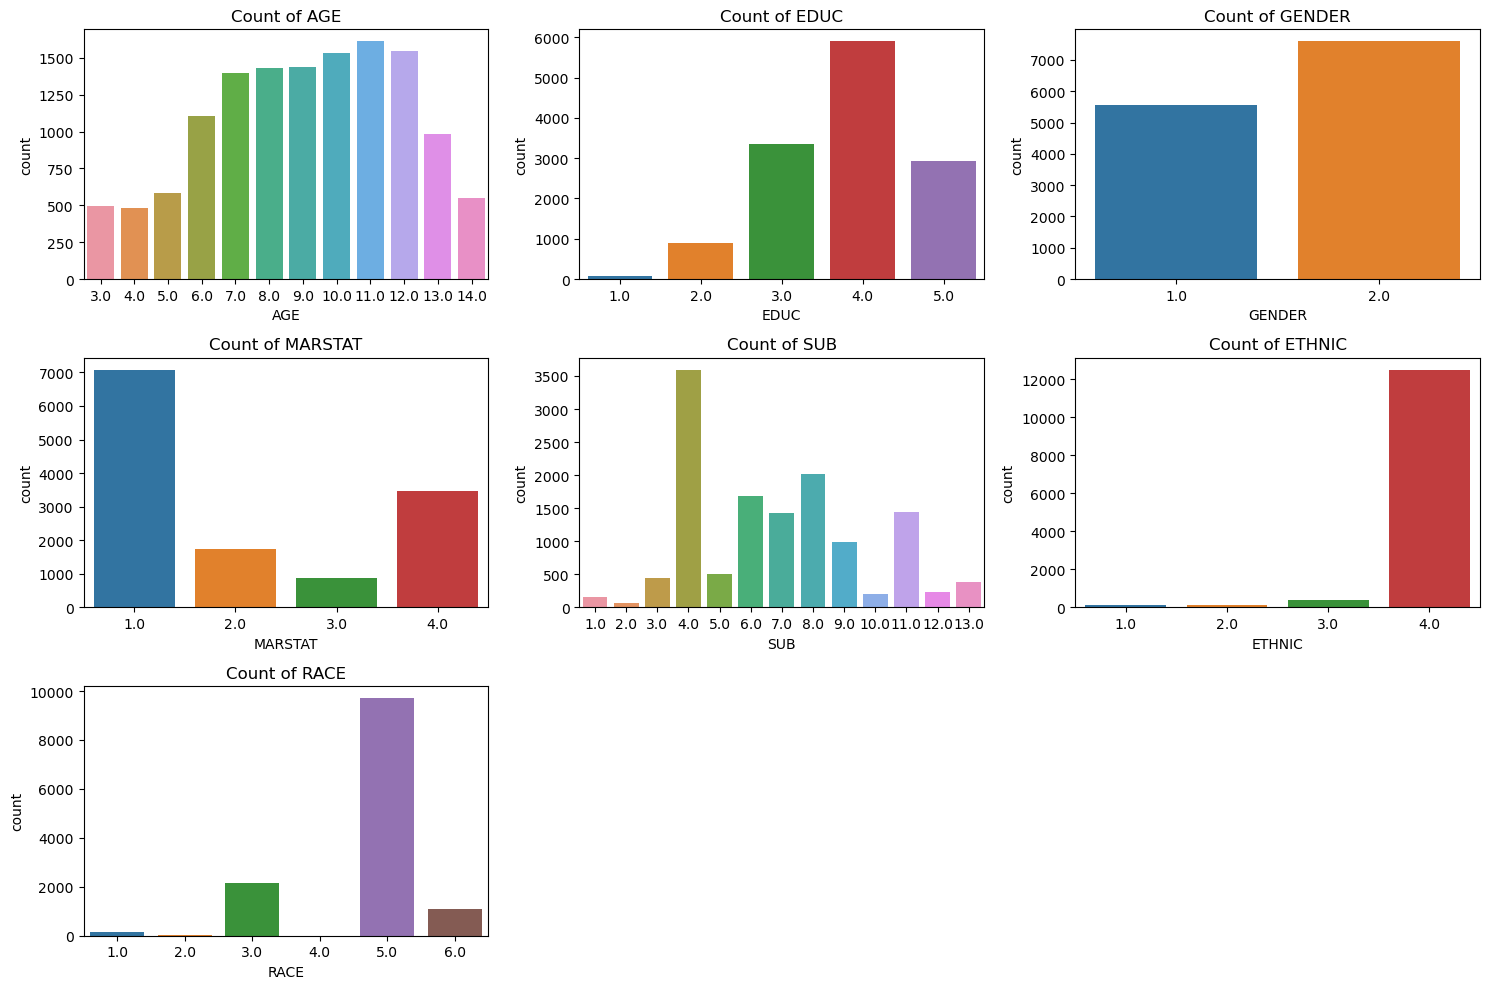

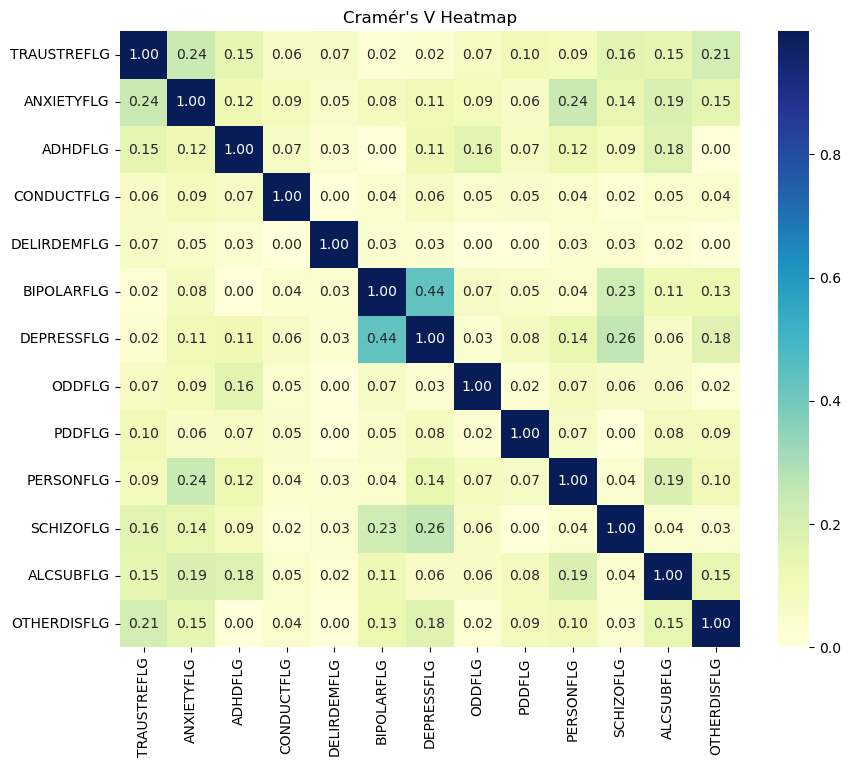

In [5]:
# Exploratory Data Analysis

MH_Flags = []

# Visualize the count of categorical features
categorical_columns = ['AGE', 'EDUC', 'GENDER', 'MARSTAT', 'SUB', 'ETHNIC', 'RACE']
plt.figure(figsize=(15, 10))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=data, x=column)
    plt.title(f'Count of {column}')
plt.tight_layout()
plt.show()


# Function to calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


# List of binary variable columns
binary_columns = ['TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG']

# Calculate Cramér's V for each pair of variables
correlations = pd.DataFrame(index=binary_columns, columns=binary_columns)

for col1 in binary_columns:
    for col2 in binary_columns:
        confusion_matrix = pd.crosstab(data[col1], data[col2])
        correlations.loc[col1, col2] = cramers_v(confusion_matrix.values)

# Convert values to numeric
correlations = correlations.apply(pd.to_numeric, errors='coerce')

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Cramér's V Heatmap")
plt.show()


In [6]:
# Select the categorical variables for one-hot encoding
categorical_variables = ["EDUC", "ETHNIC", "RACE", "GENDER", "MARSTAT", "SMISED", "SUB", "AGE", 'MH1']
df = data[categorical_variables]

In [7]:
df.head(10)

,EDUC,ETHNIC,RACE,GENDER,MARSTAT,SMISED,SUB,AGE,MH1
1005,4.0,4.0,3.0,2.0,1.0,1.0,6.0,4.0,6.0
1646,5.0,4.0,5.0,1.0,3.0,1.0,8.0,9.0,7.0
2151,3.0,4.0,5.0,2.0,4.0,1.0,7.0,14.0,7.0
3317,5.0,4.0,5.0,2.0,2.0,3.0,12.0,7.0,7.0
4579,4.0,4.0,5.0,2.0,2.0,1.0,6.0,13.0,6.0
4642,3.0,4.0,5.0,2.0,4.0,1.0,9.0,10.0,7.0
4957,4.0,4.0,3.0,2.0,1.0,1.0,7.0,8.0,7.0
5066,3.0,4.0,5.0,1.0,1.0,1.0,8.0,7.0,11.0
5410,3.0,4.0,5.0,1.0,2.0,1.0,11.0,9.0,6.0
5585,3.0,4.0,3.0,1.0,1.0,1.0,11.0,6.0,11.0


In [8]:
# Finding Optimal K
optimal_k = OptimalK(parallel_backend='multiprocessing')
n_clusters = optimal_k(df, cluster_array=np.arange(1, 10))
print(f"Optimal Number of Clusters: {n_clusters}")

Optimal Number of Clusters: 9


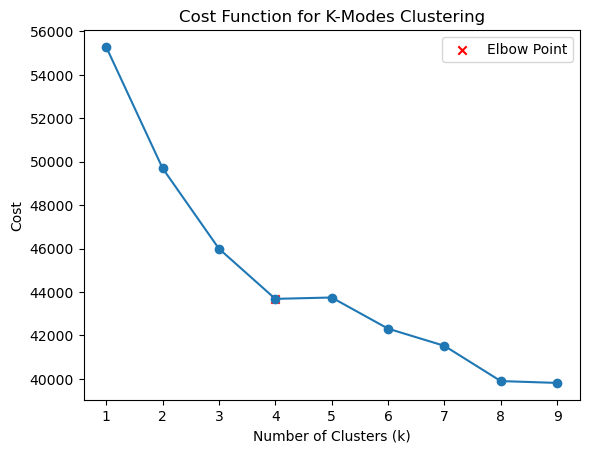

Optimal Number of Clusters: 4


In [9]:
# Cost Function

# Test multiple values of k
costs = []
k_values = range(1, 10)
for k in k_values:
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0, random_state=42)
    km.fit(df)
    costs.append(km.cost_)

# Plot the cost function
plt.plot(k_values, costs, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Cost Function for K-Modes Clustering')

# Find the elbow point
elbow_point = None
for i in range(1, len(costs)-1):
    if costs[i] < costs[i-1] and costs[i] < costs[i+1]:
        elbow_point = i + 1
        break

# Mark the elbow point on the plot
if elbow_point:
    plt.scatter(elbow_point, costs[elbow_point-1], c='red', marker='x', label='Elbow Point')

plt.legend()
plt.show()

# Print the optimal number of clusters
if elbow_point:
    print(f"Optimal Number of Clusters: {elbow_point}")
else:
    print("No clear elbow point found.")


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5207, cost: 43682.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 2628, cost: 45511.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 1980, cost: 46296.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 3464, cost: 44381.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 4390, cost: 45303.0
Run 5, iteration: 2/100, moves: 567, cost: 45303.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 3739, cost: 45217.0
Run 6, iteration: 2/100, moves: 302, cost: 45217.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, m

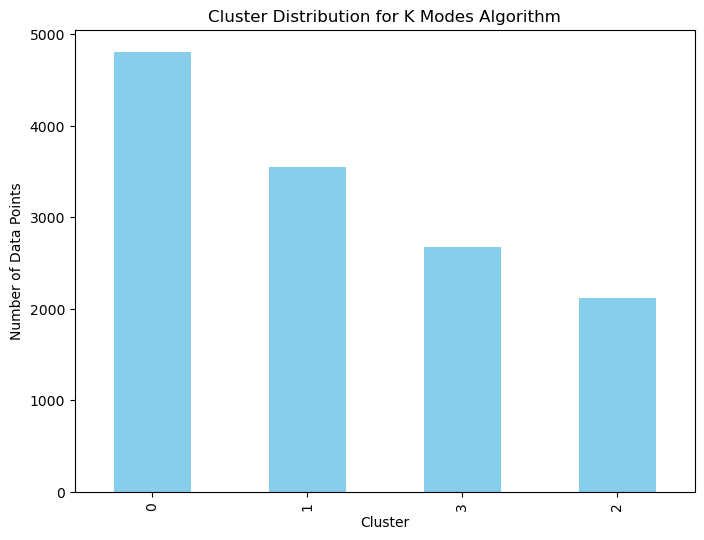

In [10]:
# K Modes Algorithm

from kmodes.kmodes import KModes

# Specify the number of clusters (k)
k = 4  # Replace with your chosen number of clusters

# Create the k-modes model
km = KModes(n_clusters=k, init='Huang', n_init=10, verbose=1, random_state=42)

# Fit the model to your data
clusters_K = km.fit_predict(df)

# K Modes clustering labels
k_modes_labels = clusters_K

# Count the number of data points in each cluster
cluster_counts_K = pd.Series(clusters_K).value_counts()

# Display the distribution of clusters
print("Cluster Distribution_K:")
print(cluster_counts_K)

# Silhouette Score (for categorical data)
silhouette_k_modes = silhouette_score(df, k_modes_labels, metric='hamming')
print("Silhouette Score for K Modes:", silhouette_k_modes)

# Visualize the distribution of clusters
plt.figure(figsize=(8, 6))
cluster_counts_K.plot(kind='bar', color='skyblue')
plt.title('Cluster Distribution for K Modes Algorithm')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.show()

In [11]:
# Fuzzy K Modes Algorithm

def fuzzy_k_modes(data, k, max_iter):
    # Initialize variables
    num_rows, num_cols = data.shape
    weight_sums = np.zeros(k)
    cluster_centroids = np.zeros((k, num_cols), dtype=object)
    labels = np.zeros(num_rows, dtype=int)
    old_labels = np.zeros(num_rows, dtype=int)
    weights = np.zeros((num_rows, k))
    change = float('inf')
    iteration = 0

    # Randomly initialize centroids
    cluster_centroids = data.sample(k).values

    # Main iteration
    while iteration < max_iter and change > 0:
        old_labels = np.copy(labels)
        weight_sums[:] = 0

        # Calculate weights
        for j in range(num_rows):
            for i in range(k):
                weights[j][i] = np.sum(data.iloc[j] != cluster_centroids[i])

        # Update labels
        labels = np.argmin(weights, axis=1)

        # Update centroids
        for i in range(k):
            cluster_points = data[labels == i]
            if len(cluster_points) > 0:
                cluster_centroids[i] = cluster_points.mode().iloc[0]

        # Check for convergence
        change = np.sum(labels != old_labels)
        iteration += 1

    return labels, cluster_centroids



num_clusters = 4
max_iterations = 100

labels, centroids = fuzzy_k_modes(df, num_clusters, max_iterations)

# Fuzzy K Modes clustering labels
fuzzy_k_modes_labels = labels

# Silhouette Score (for categorical data)
silhouette_fuzzy_k_modes = silhouette_score(df, fuzzy_k_modes_labels, metric='hamming')
print("Silhouette Score for Fuzzy K Modes:", silhouette_fuzzy_k_modes)

Silhouette Score for Fuzzy K Modes: 0.06391087816522988


Cluster 0: 6141 data points
Cluster 1: 2469 data points
Cluster 2: 2023 data points
Cluster 3: 2518 data points


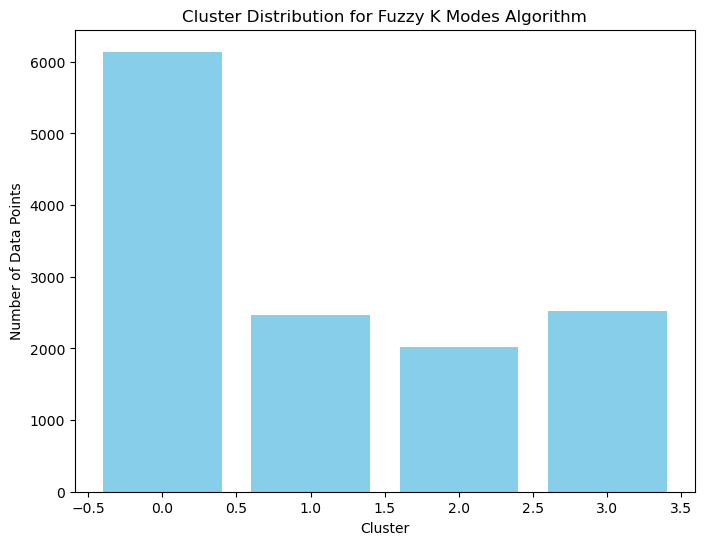

In [12]:
# Calculate cluster distribution
cluster_distribution_FKM = np.bincount(labels)

# Print cluster distribution
for cluster_FKM, count in enumerate(cluster_distribution_FKM):
    print(f"Cluster {cluster_FKM}: {count} data points")
    
# Visualize the distribution of clusters
plt.figure(figsize=(8, 6))
plt.bar(range(len(cluster_distribution_FKM)), cluster_distribution_FKM, color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Cluster Distribution for Fuzzy K Modes Algorithm')
plt.show()


In [13]:
# Hierarchical Projected Clustering for Categorical Data (HPCCD) Algorithm

def calculate_holo_entropy(subspace, data):
    return data[subspace].nunique().sum() / len(data)

def initialize_clusters(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data['cluster'] = kmeans.fit_predict(data)
    return data['cluster'].values

def relevant_subspace_selection(subcluster, data):
    entropy_values = data.apply(lambda col: calculate_holo_entropy([col.name], data))
    sorted_entropy = entropy_values.sort_values(ascending=False)
    return sorted_entropy.index.tolist()

def intrinsic_compactness(subcluster, data):
    return calculate_holo_entropy(subcluster, data)

def hpccd_algorithm(data, n_clusters, desired_clusters):
    # Step 1: Initialize clusters using K-Means
    initial_clusters = initialize_clusters(data, n_clusters)

    # Step 2: Iteratively merge clusters until reaching the desired number
    while len(data['cluster'].unique()) > desired_clusters:
        relevant_subspaces = []

        # Calculate relevant subspaces for each cluster
        for cluster in data['cluster'].unique():
            cluster_data = data[data['cluster'] == cluster]
            relevant_subspace = relevant_subspace_selection(cluster_data, data)
            relevant_subspaces.append(relevant_subspace)

        weights = []

        # Assign weights for each relevant subspace
        for relevant_subspace in relevant_subspaces:
            weights.append([1 / (len(data[relevant_subspace]) + 0.0001)] * len(relevant_subspace))

        compactness_matrix = np.zeros((len(relevant_subspaces), len(relevant_subspaces)))

        # Calculate intrinsic compactness for each pair of clusters
        for i in range(len(relevant_subspaces)):
            for j in range(i + 1, len(relevant_subspaces)):
                compactness_matrix[i, j] = intrinsic_compactness(relevant_subspaces[i], data)
                compactness_matrix[j, i] = intrinsic_compactness(relevant_subspaces[j], data)

        # Find the pair of clusters with the minimum compactness
        min_compactness_index = np.unravel_index(np.argmin(compactness_matrix, axis=None), compactness_matrix.shape)
        cluster_to_merge_1 = data['cluster'].unique()[min_compactness_index[0]]
        cluster_to_merge_2 = data['cluster'].unique()[min_compactness_index[1]]

        # Merge the clusters
        data['cluster'] = data['cluster'].replace({cluster_to_merge_1: desired_clusters + 1, cluster_to_merge_2: desired_clusters + 1})

    # Print the final number of clusters
    print("Final Number of Clusters:", len(data['cluster'].unique()))

    # Print the resulting clusters
    print("Cluster Labels:")
    print(data['cluster'].values)

    return data['cluster'].values


n_clusters_value = 4  # Set an initial number of clusters for K-Means
desired_clusters_value = 4  # Set the desired number of clusters

# Run the HPCCD algorithm with the desired number of clusters
result_clusters = hpccd_algorithm(df, n_clusters_value, desired_clusters_value)

# HPCCD clustering labels
hpccd_labels = result_clusters

# Print the resulting clusters
print("Resulting Clusters:")
print(result_clusters)

# Silhouette Score (for categorical data)
silhouette_hpccd = silhouette_score(df, hpccd_labels, metric='hamming')
print("Silhouette Score for HPCCD:", silhouette_hpccd)

  File "C:\Users\supri\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\supri\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\supri\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\supri\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Final Number of Clusters: 4
Cluster Labels:
[1 3 0 ... 3 0 2]
Resulting Clusters:
[1 3 0 ... 3 0 2]
Silhouette Score for HPCCD: 0.20290842215086632


Cluster 0: 3888 data points
Cluster 1: 3055 data points
Cluster 2: 3545 data points
Cluster 3: 2663 data points


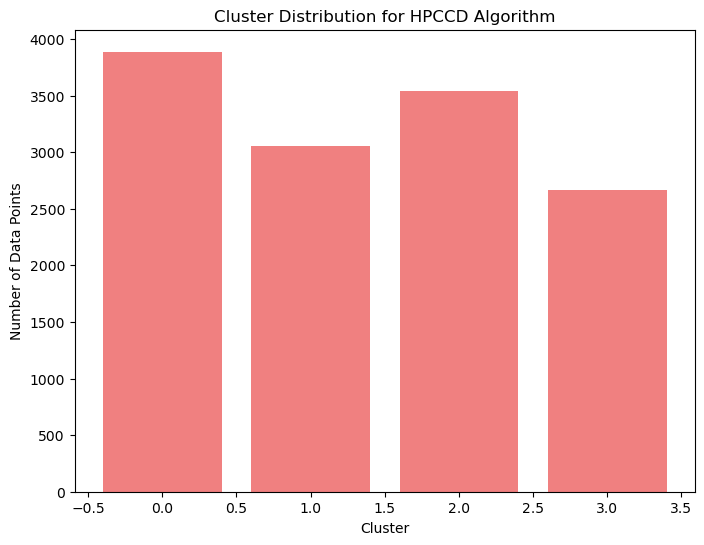

In [14]:
# Calculate cluster distribution
cluster_distribution_hpccd = np.bincount(result_clusters)

# Print cluster distribution
for cluster, count in enumerate(cluster_distribution_hpccd):
    print(f"Cluster {cluster}: {count} data points")

# Visualize the distribution of clusters for HPCCD algorithm
plt.figure(figsize=(8, 6))
plt.bar(range(len(cluster_distribution_hpccd)), cluster_distribution_hpccd, color='lightcoral')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Cluster Distribution for HPCCD Algorithm')
plt.show()

In [15]:
df.head()

,EDUC,ETHNIC,RACE,GENDER,MARSTAT,SMISED,SUB,AGE,MH1,cluster
1005,4.0,4.0,3.0,2.0,1.0,1.0,6.0,4.0,6.0,1
1646,5.0,4.0,5.0,1.0,3.0,1.0,8.0,9.0,7.0,3
2151,3.0,4.0,5.0,2.0,4.0,1.0,7.0,14.0,7.0,0
3317,5.0,4.0,5.0,2.0,2.0,3.0,12.0,7.0,7.0,3
4579,4.0,4.0,5.0,2.0,2.0,1.0,6.0,13.0,6.0,0


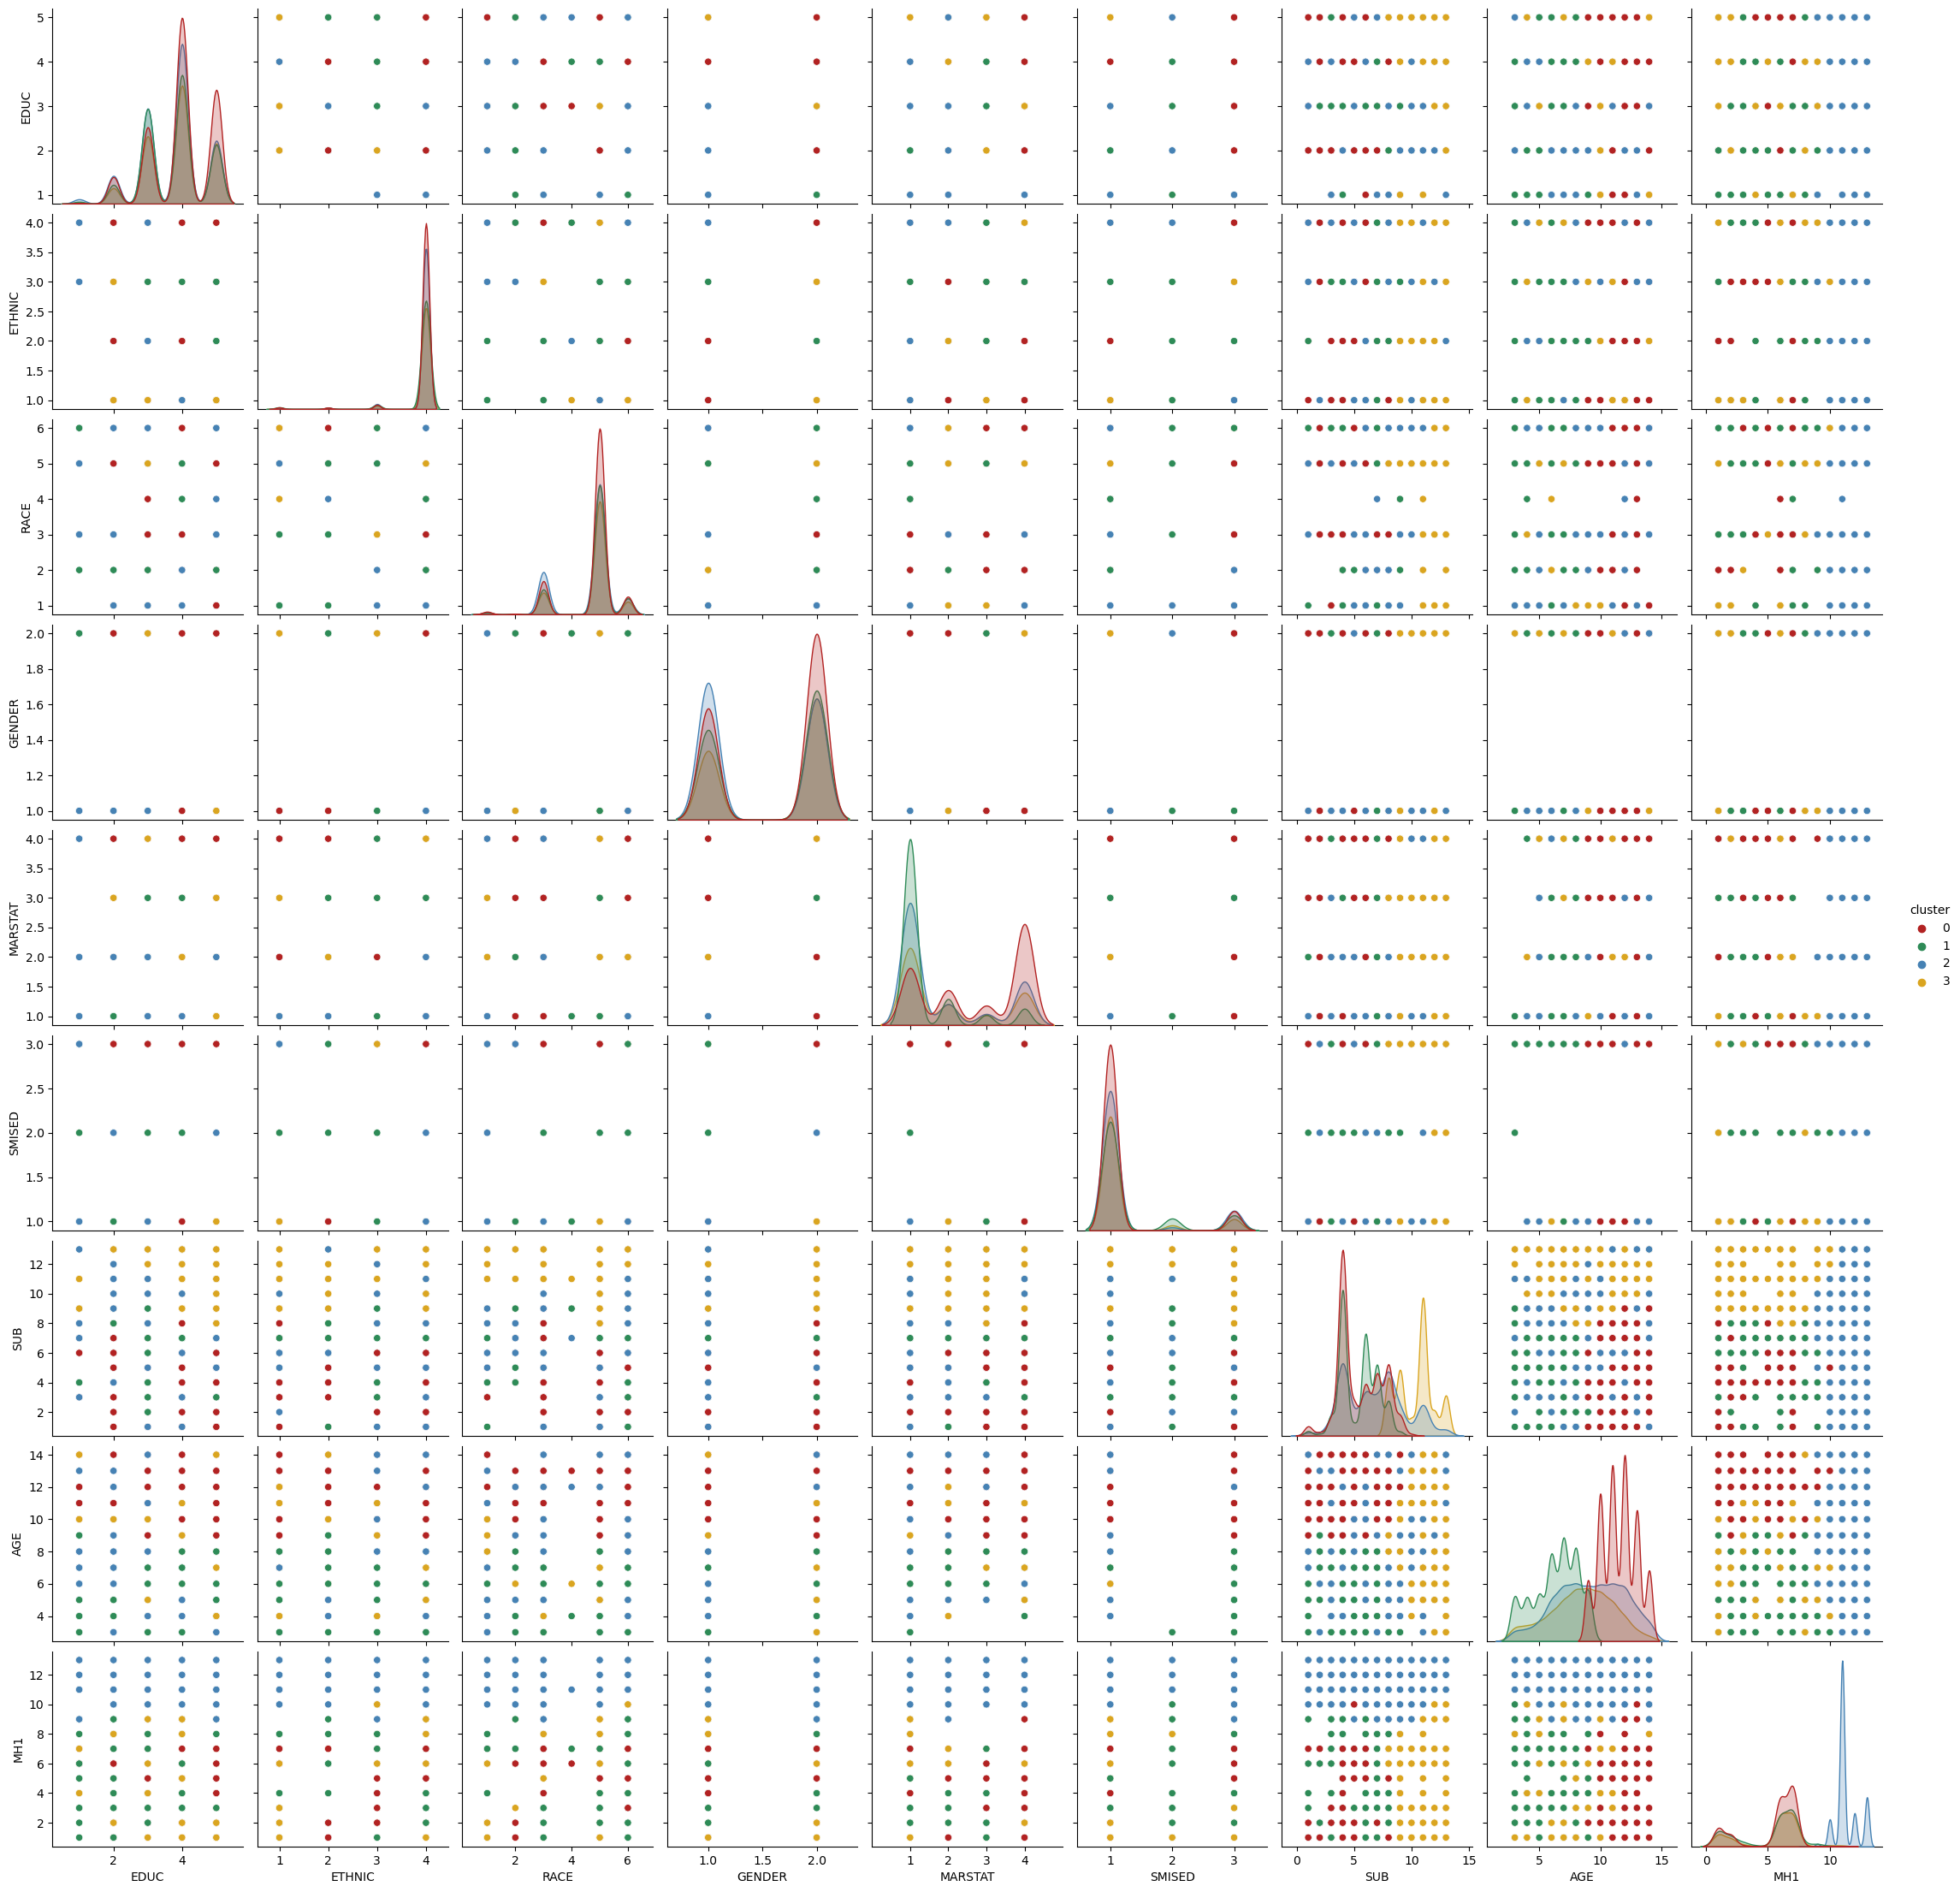

In [16]:
# Scatter plot 

# Define a color palette for each cluster
cluster_palette = {0: 'firebrick', 1: 'seagreen', 2: 'steelblue', 3: 'goldenrod'}
sns.pairplot(df, hue='cluster', palette = cluster_palette)
plt.show()

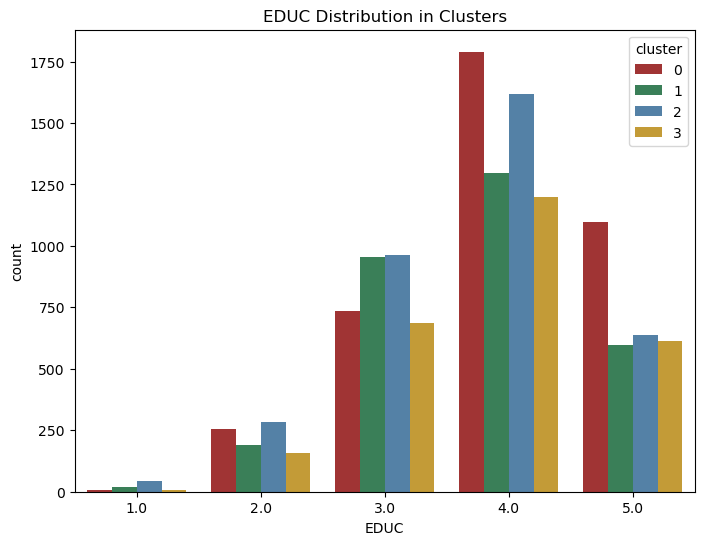

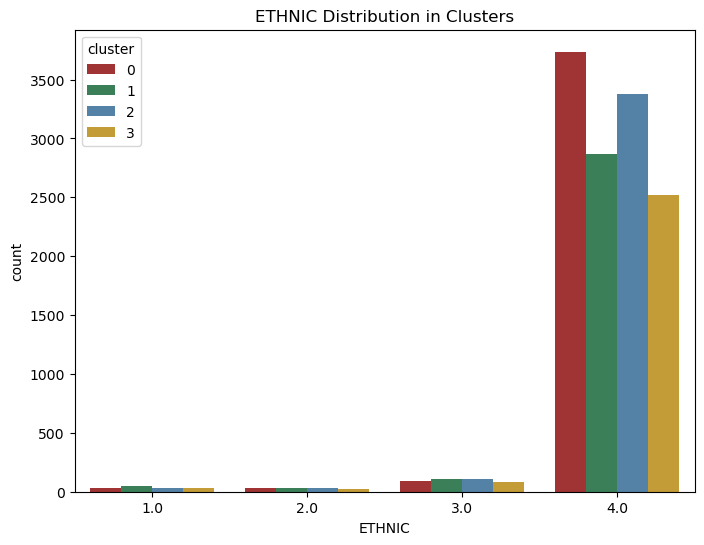

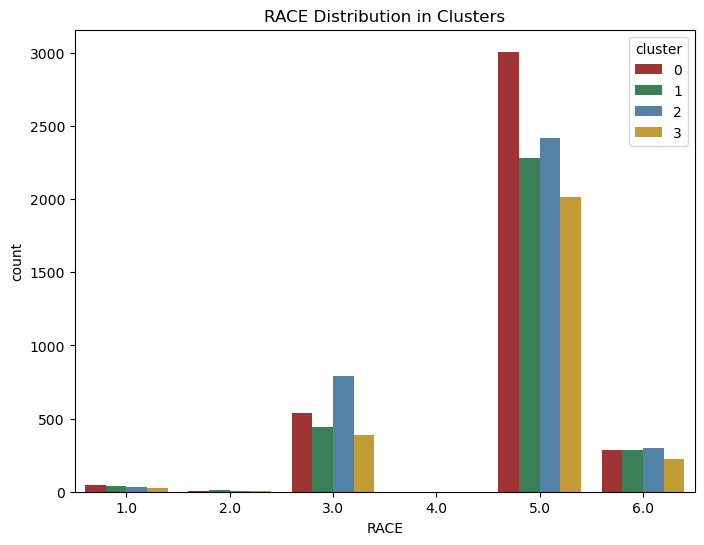

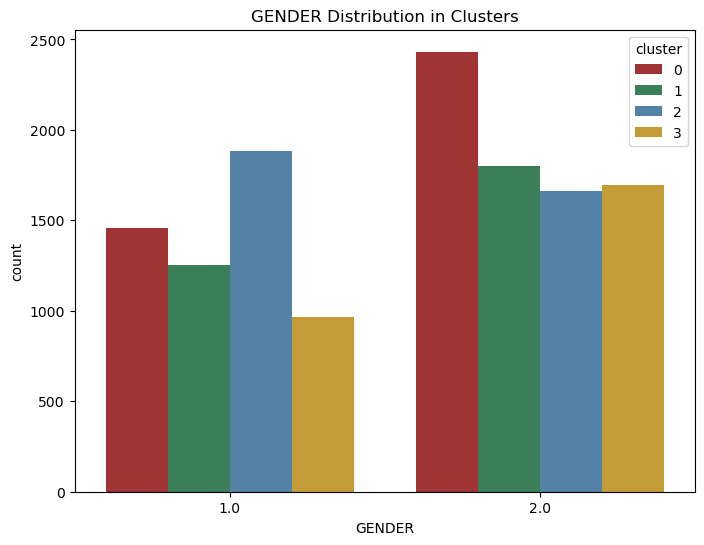

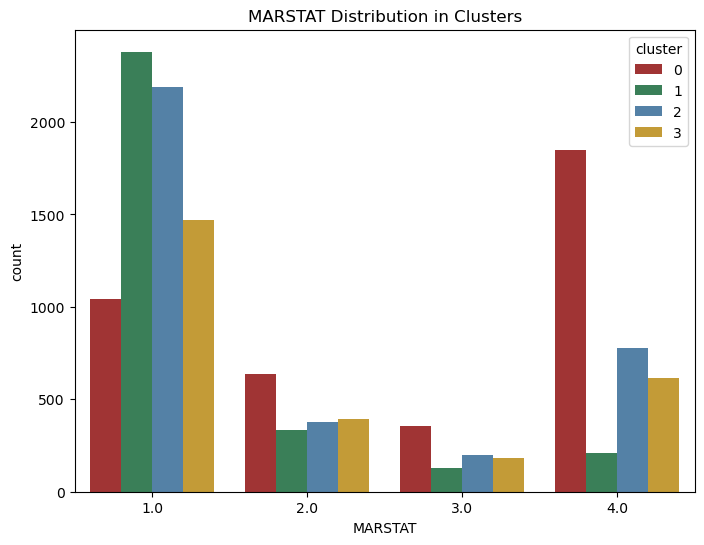

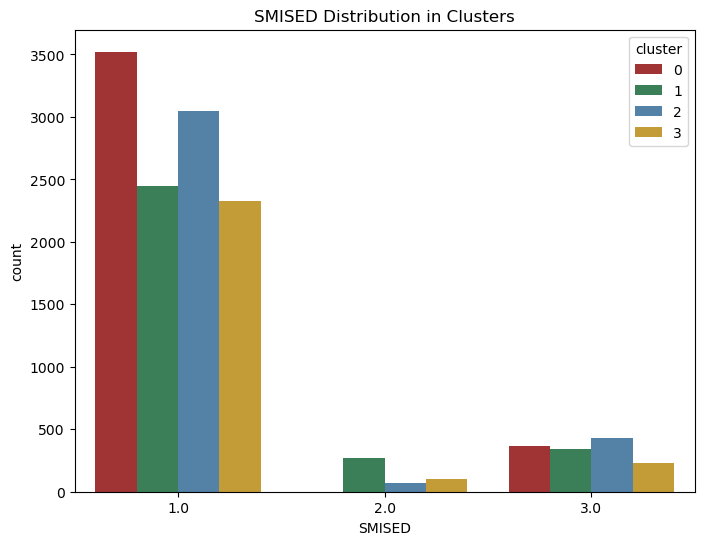

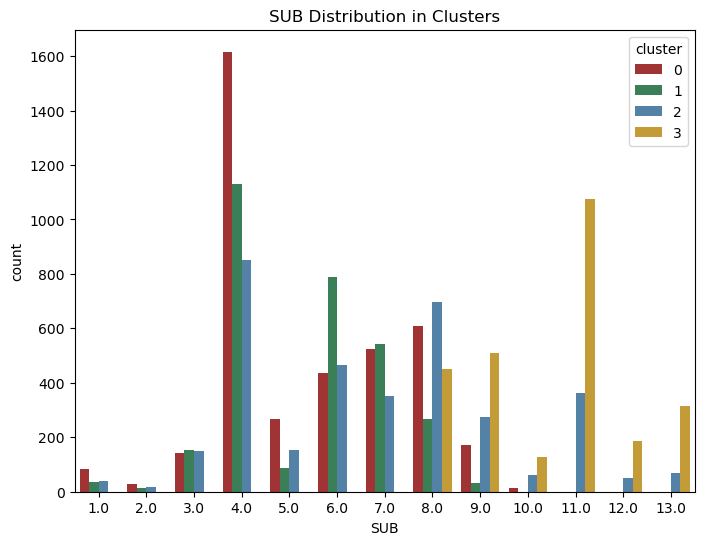

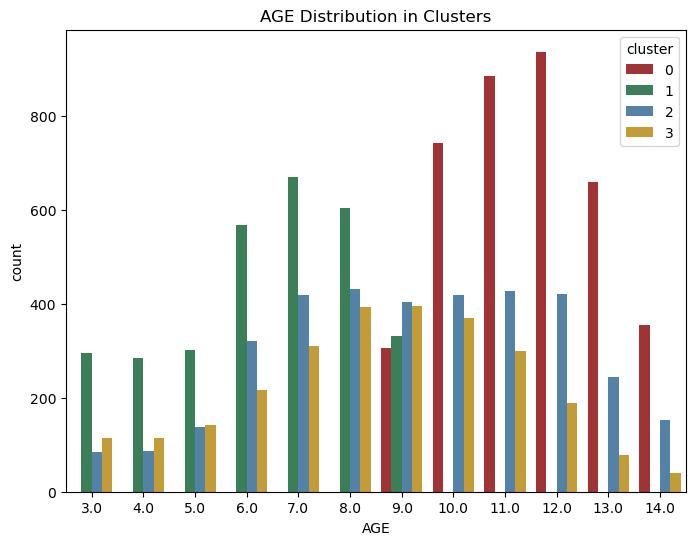

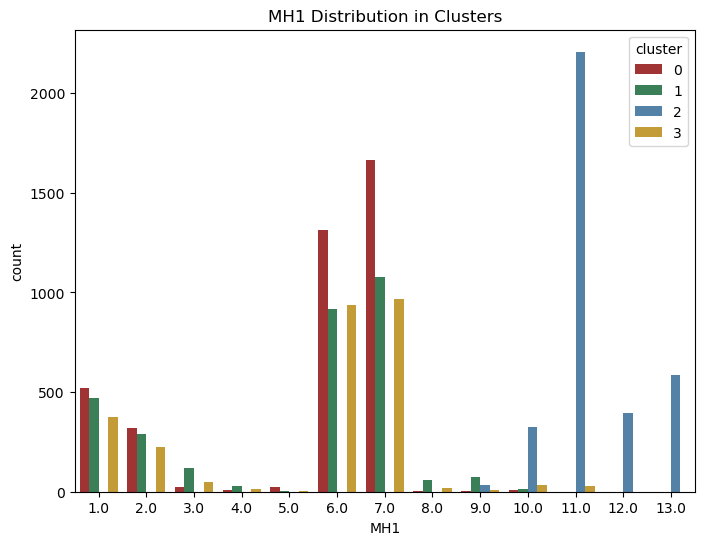

In [17]:
# Variables distribution in clusters

features = ["EDUC", "ETHNIC", "RACE", "GENDER", "MARSTAT", "SMISED", "SUB", "AGE", 'MH1'] 
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=feature, hue='cluster', data=df, palette = cluster_palette)  # Replace 'Cluster' with your cluster column name
    plt.title(f'{feature} Distribution in Clusters')
    plt.show()

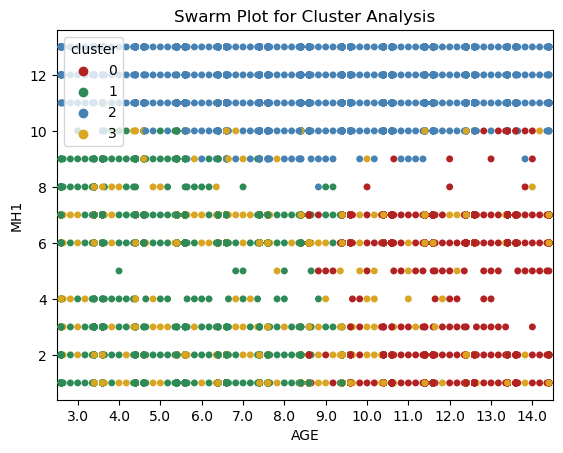

In [18]:
# Swarm plot of AGE and MH1

sns.swarmplot(x='AGE', y='MH1', hue='cluster', data=df, palette = cluster_palette)
plt.title('Swarm Plot for Cluster Analysis')
plt.show()

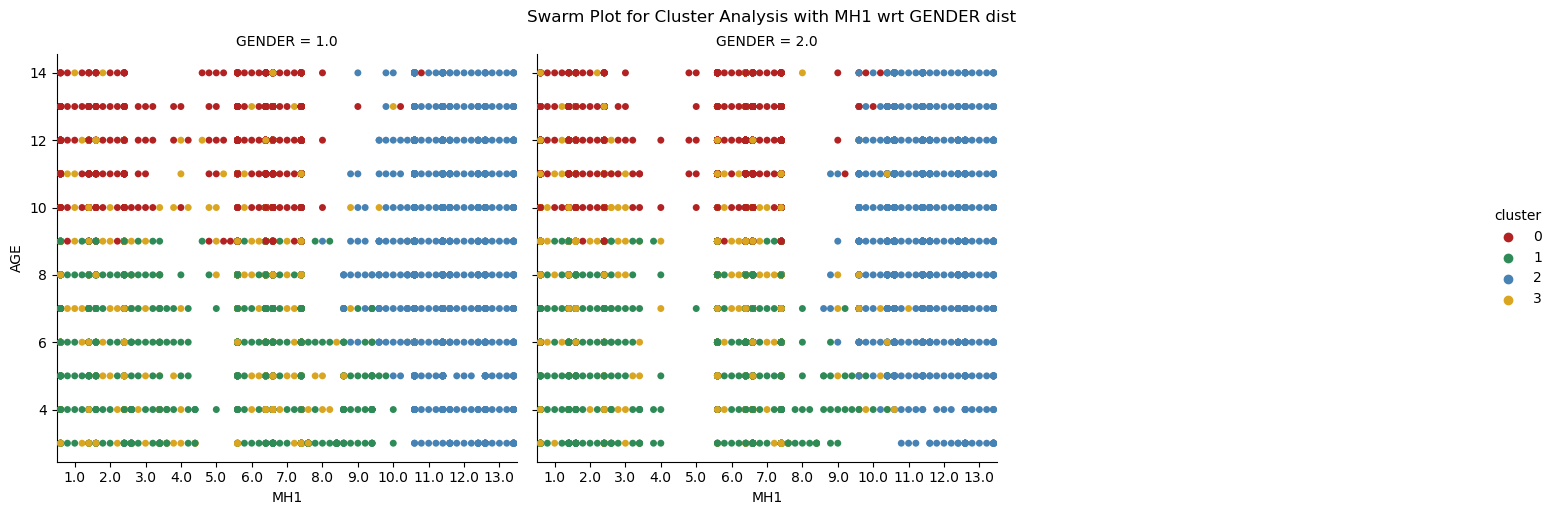

In [19]:
# Swarm plot of AGE and MH1 wrt GENDER dist

sns.catplot(data=df, x='MH1', y='AGE', kind='swarm', hue='cluster', palette = cluster_palette, col='GENDER', col_wrap=3)
plt.suptitle('Swarm Plot for Cluster Analysis with MH1 wrt GENDER dist', y=1.02)
plt.show()

<Figure size 1200x800 with 0 Axes>

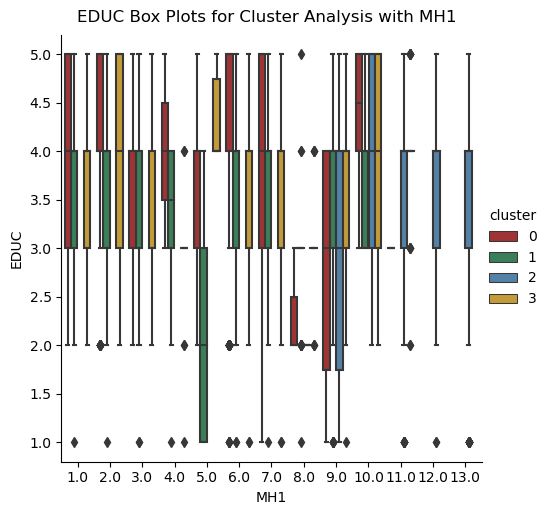

<Figure size 1200x800 with 0 Axes>

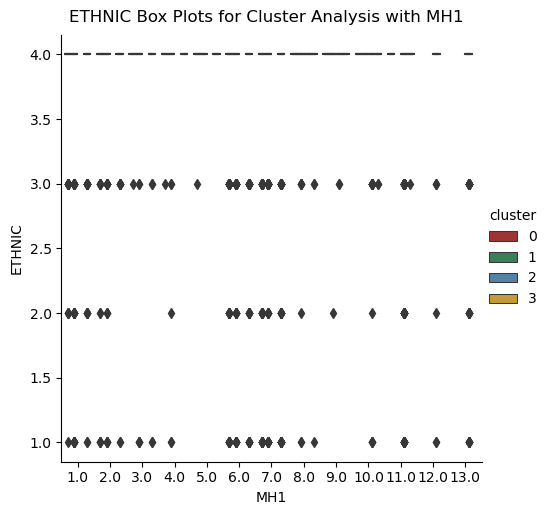

<Figure size 1200x800 with 0 Axes>

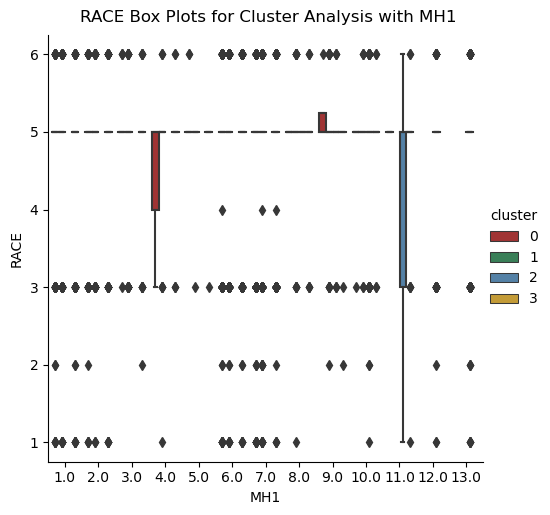

<Figure size 1200x800 with 0 Axes>

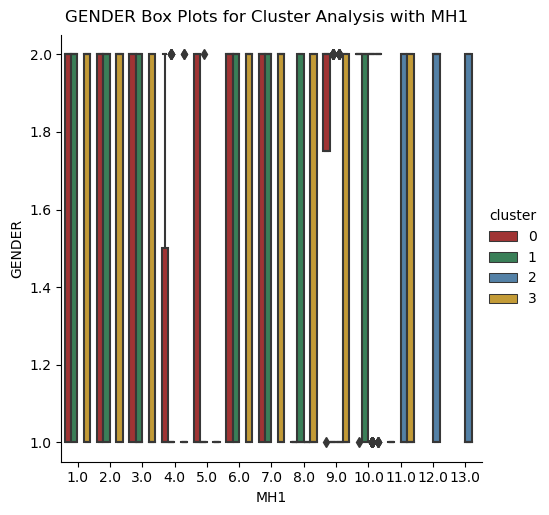

<Figure size 1200x800 with 0 Axes>

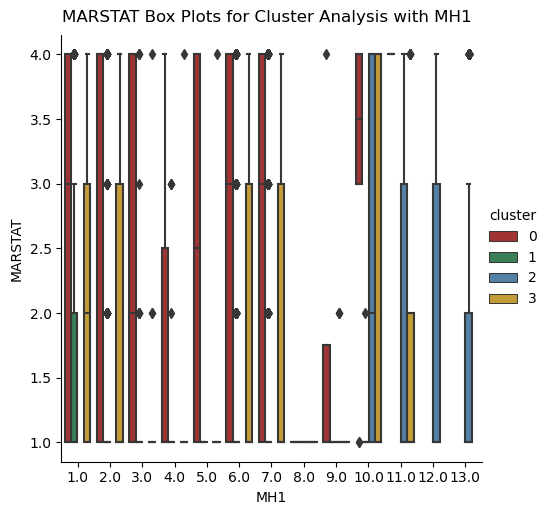

<Figure size 1200x800 with 0 Axes>

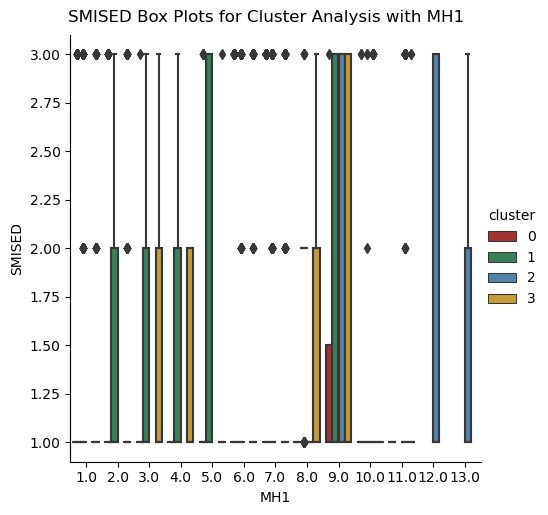

<Figure size 1200x800 with 0 Axes>

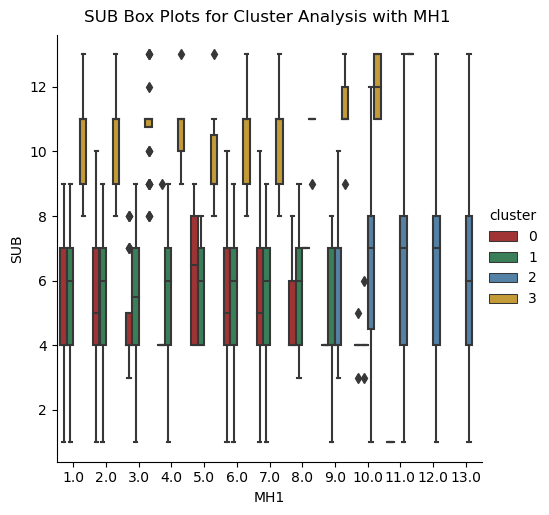

<Figure size 1200x800 with 0 Axes>

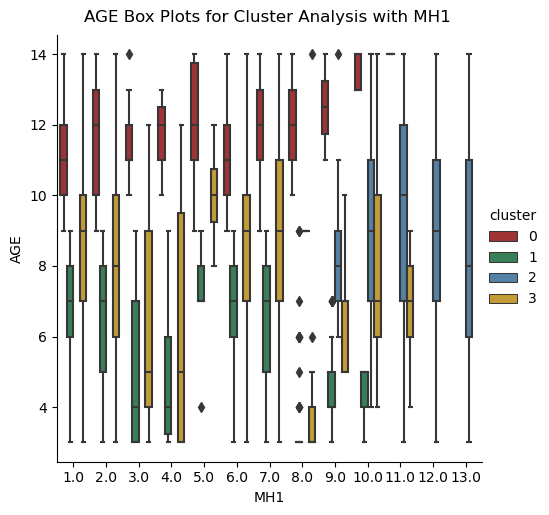

In [20]:
# BOX plots of Variables by MH1

features = ["EDUC", "ETHNIC", "RACE", "GENDER", "MARSTAT", "SMISED", "SUB", "AGE", ] 
for feature in features:
    plt.figure(figsize=(12, 8))
    sns.catplot(data=df, kind='box',y = feature, x='MH1', hue='cluster', palette = cluster_palette)
    plt.suptitle(f'{feature} Box Plots for Cluster Analysis with MH1', y=1.02)
    plt.show()

<Figure size 1200x800 with 0 Axes>

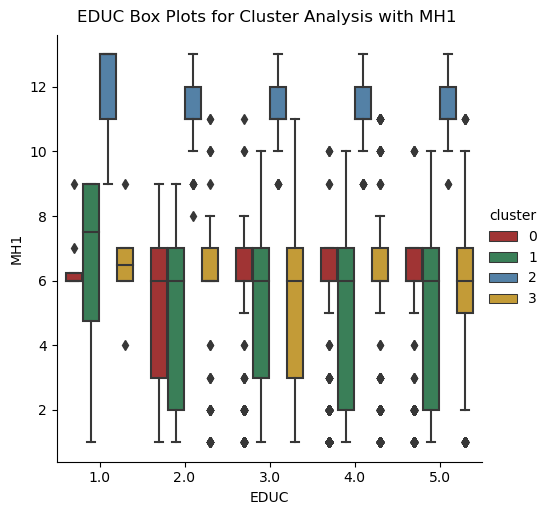

<Figure size 1200x800 with 0 Axes>

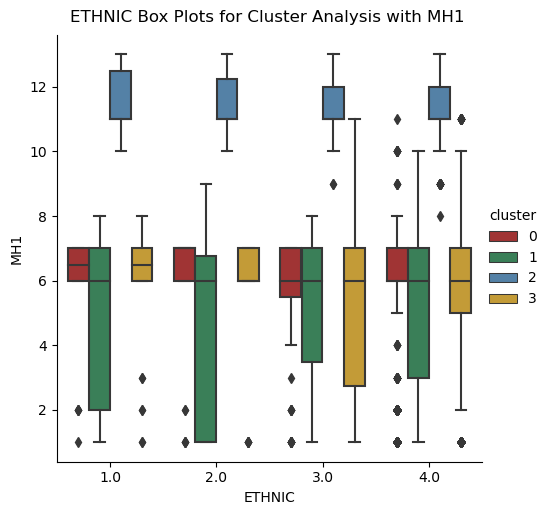

<Figure size 1200x800 with 0 Axes>

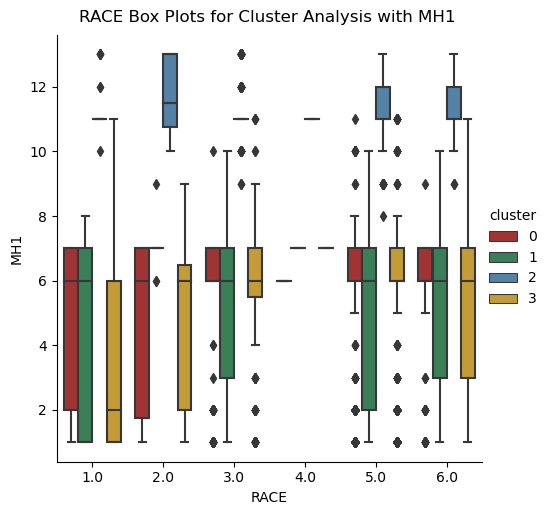

<Figure size 1200x800 with 0 Axes>

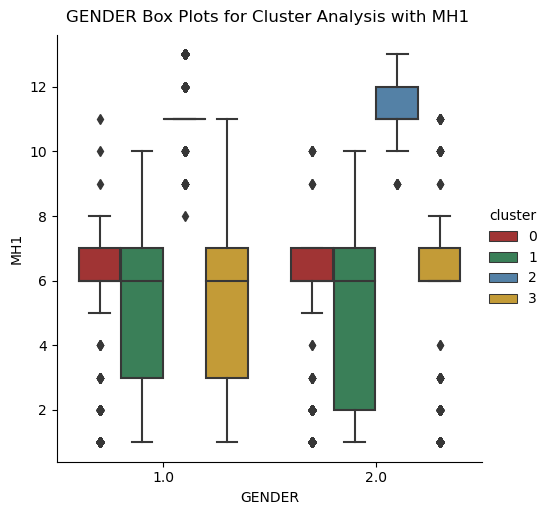

<Figure size 1200x800 with 0 Axes>

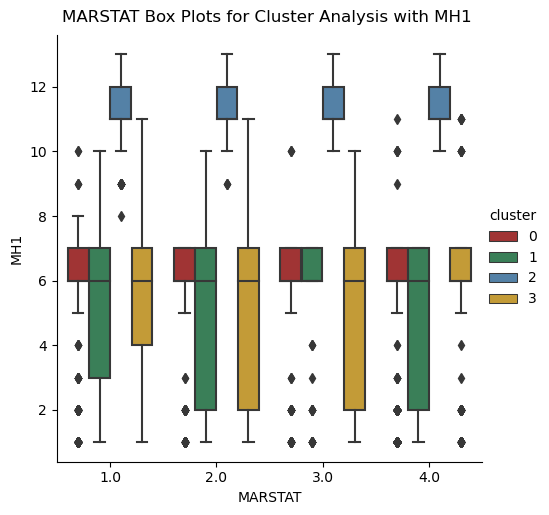

<Figure size 1200x800 with 0 Axes>

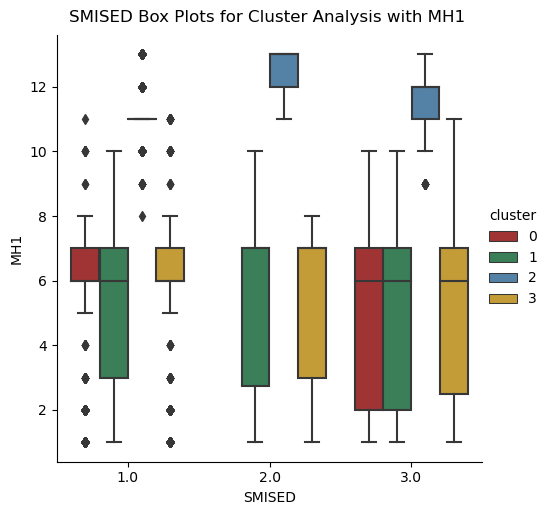

<Figure size 1200x800 with 0 Axes>

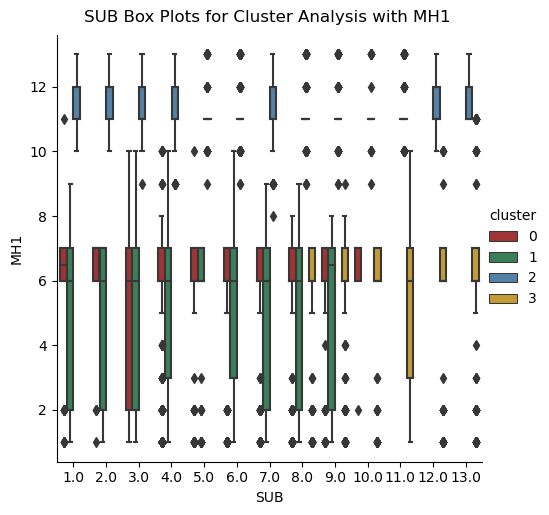

<Figure size 1200x800 with 0 Axes>

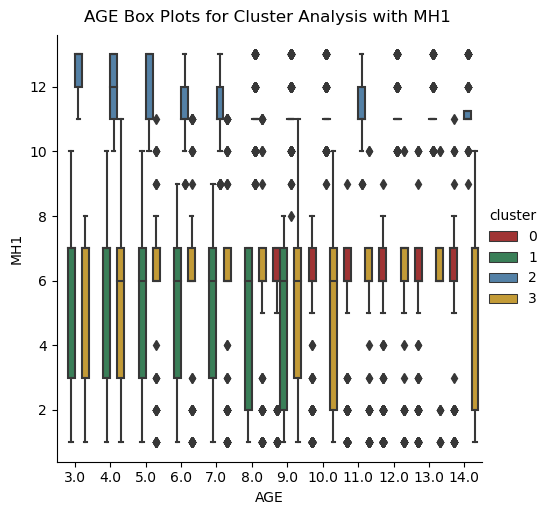

In [21]:
# BOX plots of MH1 by Variables

features = ["EDUC", "ETHNIC", "RACE", "GENDER", "MARSTAT", "SMISED", "SUB", "AGE", ] 
for feature in features:
    plt.figure(figsize=(12, 8))
    sns.catplot(data=df, kind='box',x = feature, y ='MH1', hue='cluster', palette = cluster_palette)
    plt.suptitle(f'{feature} Box Plots for Cluster Analysis with MH1', y=1.02)
    plt.show()

### REFERENCES

[1] 2021 mental health client-level data (MH-CLD) detailed tables. SAMHSA.gov. (n.d.). https://www.samhsa.gov/data/report/2021-mhcld-detailed-tables

[2] https://www.samhsa.gov/data/sites/default/files/reports/rpt42719/2021-mhcld-annual-detailed-tables.pdf

[3] MH-CLD-2021-DS0001-info-codebook.pdf
